In [1]:
################################################### IMPORT #########################################################
# importing of all needed libraries and modules.  
import wrangle as w
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats
from scipy.stats import pearsonr, spearmanr
from sklearn.feature_selection import SelectKBest, RFE, f_regression, SequentialFeatureSelector
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
import sklearn.preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error
import os
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")


In [2]:
train, validate, test=w.wrangle_zillow()

In [3]:
train.head()

,bedrooms,bathrooms,squarefeet,home_value
43512,3.0,2.0,1005.0,137514.0
5257,5.0,3.0,2194.0,555300.0
41617,3.0,2.0,1159.0,588845.0
30688,2.0,1.0,1024.0,890558.0
45903,3.0,2.0,1464.0,216450.0


In [4]:
train.corr()

,bedrooms,bathrooms,squarefeet,home_value
bedrooms,1.000000,0.603400,0.617500,0.236742
bathrooms,0.603400,1.000000,0.792866,0.400676
squarefeet,0.617500,0.792866,1.000000,0.462310
home_value,0.236742,0.400676,0.462310,1.000000


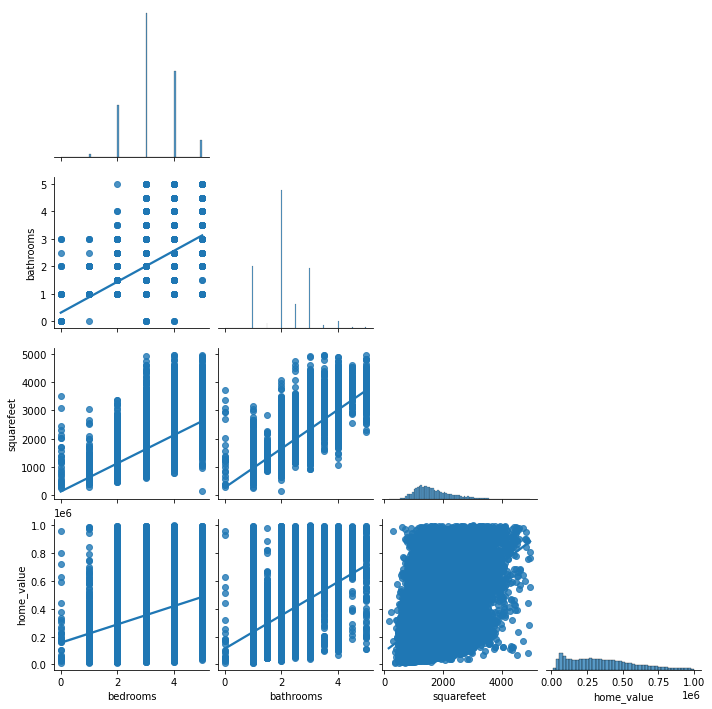

In [5]:
sns.pairplot(data=train, kind="reg", corner=True)